### Intro

We are Ronen lubin (322702275) and Osher Baron (123456789), young computer science students who are passionate about data science.

Since we both like realestate we knew from the beginning of the semester that our project would deal with this topic


### The problem

A lot of people struggle with the question of how much their house is worth
and how much the house will be worth in the future.

We have decided to put an end to this problem for those living in israel

# Obtaininng the data
Our data source for this project is a israeli realestate website called 'Homeless'.
you can go visit the website : https://www.homeless.co.il/sale/

there are tens of thousands of homes for sale in the website and equal amount of rental apartments .

the website does not provide an API for obtaininng the data on the homes,
so we had to build a web scraping tool in order to obtain the information.


### Building the web scraping tool
we used the beautifulsoup python package for this mission.

the code segment below is browsing in the first 160 pages of homes for sale in the website.
for each main page the code extracts the links to the house info,
there are 25 links in each page so in total the method 'get_all_links' return 4000 homes info links.

In [2]:
from bs4 import BeautifulSoup
import requests


# return the apartment id from html element
def get_apartment_id(apartment):
    id_text = apartment['id']
    return id_text.split('_').pop(1)


# constructs new apartment link from the apartments id
def make_link(id):
    return "https://www.homeless.co.il/Sale/viewad," + id + ".aspx"


# return all the apartments links from specific page in the website
def get_apartments_links(page_link="https://www.homeless.co.il/sale/1500"):
    htmt_text = requests.get(page_link).text
    soup = BeautifulSoup(htmt_text, "lxml")
    not_brokerage = soup.find("div", id="display_table")

    apartments = not_brokerage.find_all('tr', type="ad")

    apartments_links = []
    for apartment in apartments:
        id = get_apartment_id(apartment)
        new_link = make_link(id)
        apartments_links.append(new_link)

    return apartments_links


# goes to the specified number page
def go_to_page(page_number):
    return "https://www.homeless.co.il/sale/" + str(page_number)


# return all the apartments links in the website
def get_all_links():
    all_links = []
    for i in range(0, 160):
        links_on_page = get_apartments_links(go_to_page(i))
        all_links = all_links + links_on_page
    return all_links


### Extracting the data from the html content
for each link from the 4000 links we extract the data on the house that the link describes.
the data includes the city where the house is located, the price of the house in the website, the area of the house in sqr m, 
the type of the house, the number of rooms in the house, whether  the house contain bars, whether the house contains furniture, whether there is an elvator in the building, if the is a parking nearby and if air condition is insalled indside the house.


In [3]:
from bs4 import BeautifulSoup
import requests

class Apartment:
    def __init__(self, city, price, area, house_type, rooms, bars, furniture, lift, parking, air_condition):
        self.city = city
        self.price = price
        self.area = area
        self.house_type = house_type
        self.rooms = rooms
        self.bars = bars
        self.furniture = furniture
        self.lift = lift
        self.parking = parking
        self.air_condition = air_condition

    def get_city(self):
        return self.city

    # return the price converted to int
    def get_price(self):
        try:
            price_int = (int(self.price.replace(',', '')))
            return price_int
        except ValueError:
            return 0

    def get_area(self):
        try:
            return int(self.area)
        except ValueError:
            return 0

    def get_house_type(self):
        return self.house_type

    def get_rooms(self):
        return self.rooms

    def get_bars(self):
        return 1 if self.bars else 0

    def get_furniture(self):
        return 1 if self.furniture else 0

    def get_lift(self):
        return 1 if self.lift else 0

    def get_parking(self):
        return self.parking

    def get_air_condition(self):
        return self.air_condition

    
# return true if the image us of type "/Images/checked.png"
def image_checked(image):
    if image == "/Images/uncheked.png":
        return False
    elif image == "/Images/checked.png":
        return True
    

# return the city where the house is located
def get_city(soup):
    ul_html = soup.find("ul", class_="breadcrumb")
    li_html = ul_html.find_all("a")[1]
    city_html = li_html["href"]
    city = city_html.split("$$")[0].split("=")[1]
    return city


# return the price of the house
def get_price(soup):
    price_html = soup.find("div", class_="price")
    return price_html.text.split().pop(1)


# return the area of the house in squre meters
def get_area(soup):
    balcony_html = soup.find_all("div", style="float:right; width:130px;")[3].text
    return balcony_html.split(':')[1].split('\n')[0]


# return the number of rooms in the house
def get_rooms(soup):
    rooms_html = soup.find("div", class_="right")
    rooms_text = rooms_html.find("h1").string
    return rooms_text.split(',').pop(1).split(' ').pop(1)


# return the house type ( apartment, private home, penthouse .....)
def get_house_type(soup):
    type_html = soup.find("div", class_="right")
    type_text = type_html.find("h1").string
    return type_text.split(',').pop(0)


# return if the house has bars
def has_bars(soup):
    image = soup.find_all("img", class_="itemsAd")[0]["src"]
    return image_checked(image)


# return if the house has furniture
def has_furniture(soup):
    image = soup.find_all("img", class_="itemsAd")[1]["src"]
    return image_checked(image)


# return if the house has lift
def has_lift(soup):
    image = soup.find_all("img", class_="itemsAd")[2]["src"]
    return image_checked(image)


# return the parking in the house
def get_parking(soup):
    parking_html = soup.find_all("div", style="float:right; width:180px;")[1].text
    return parking_html.split(':')[1]


# return the type of air condition
def get_air_condition(soup):
    air_condition = soup.find_all("div", style="float:right; width:180px;")[2].text
    return air_condition.split(':')[1]


# return all the apartments objects
def get_data():
    apartments_links = get_all_links()

    apartments = []
    for apartment_link in apartments_links:
        htmt_text = requests.get(apartment_link).text
        soup = BeautifulSoup(htmt_text, "lxml")

        try:
            city = get_city(soup)
            price = get_price(soup)
            squre_meter = get_area(soup)
            house_type = get_house_type(soup)
            rooms = get_rooms(soup)
            lift = has_lift(soup)
            furniture = has_furniture(soup)
            bars = has_bars(soup)
            parking = get_parking(soup)
            air_condition = get_air_condition(soup)
            new_apartment = Apartment(city, price, squre_meter, house_type, rooms, bars, furniture, lift,
                                      parking, air_condition)

            apartments.append(new_apartment)

        except :
            print("exception in link:" + apartment_link)

    return apartments

### Writing the data to csv file
after we scrapped the info about the homes we sould write it into a csv file, in order to use the informatiom in the future.   
the code down below acomplish this mission:


In [1]:
import csv


# writes the apartments data to the csv file
def write_to_csv():

    apartments_data = get_data()
    print("finished to gather the data")

    with open('apartments1.csv', "w", newline='', encoding="utf-8") as csvfile:
        csv_writer = csv.writer(csvfile)
        head_line = ['city', 'price', 'area', 'house type', 'rooms', 'bars', 'furniture', 'lift',
                     'parking', 'air condition']
        csv_writer.writerow(head_line)

        for apartment in apartments_data:
            row = []

            row.append(apartment.get_city())
            row.append(apartment.get_price())
            row.append(apartment.get_area())
            row.append(apartment.get_house_type())
            row.append(apartment.get_rooms())
            row.append(apartment.get_bars())
            row.append(apartment.get_furniture())
            row.append(apartment.get_lift())
            row.append(apartment.get_parking())
            row.append(apartment.get_air_condition())

            csv_writer.writerow(row)
            
write_to_csv()

NameError: name 'get_data' is not defined

### Run Time
after testing a few runs in the real world we can say confidently that the web scrapper runs in O(N) time complexity (where N is the number of homes).
it took the program approximatly 4600 seconds (1 hour and 17 minutes) to complete the run on 4000 homes, and it took 77 seconds to complete the run on input of 75 homes. a little bit more then 1 second for each apartments on our setup.



# Exploratory data analysis

now after we obtained the data lets export the data set into pandas data frame.
but first we have to import pandas


In [172]:
import pandas as pd

df = pd.read_csv("apartments.csv")
df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000,90,דו משפחתי,4.0,1,0,0,חניה משותפת,בחדרים ובסלון
1,רמת גן,2750000,90,בית פרטי,4.0,1,0,0,אין,בחדרים ובסלון
2,תל אביב יפו,13000000,157,דופלקס,6.0,0,0,1,פרטית - לא מקורה,בחדרים
3,תל אביב יפו,1350000,57,דירה,2.5,1,1,0,ברחוב,בחדרים ובסלון
4,באר שבע,1570000,160,דירה,4.0,0,0,1,פרטית - מקורה,בחדרים ובסלון
...,...,...,...,...,...,...,...,...,...,...
3974,ראשון לציון,1670000,90,דירה,4.0,0,0,1,פרטית - מקורה,בחדרים ובסלון
3975,ראשון לציון,2470000,340,בית פרטי,4.0,0,0,0,פרטית - לא מקורה,בחדרים ובסלון
3976,הוד השרון,0,0,דירת גג,7.0,0,0,1,פרטית - מקורה,בסלון
3977,קרית גת,1850000,146,פנטהאוז,5.5,0,1,1,פרטית - לא מקורה,מיני מרכזי


as you can see there were few exeptions hence we have 3979 rows in the data set and not 4000 rows.


## Cleaning the data
in this section we clear the raw data in order use it later for visiulision and AI.

firstly lets see if we have duplictate rows in our data set:

we have 96 duplicated rows, so lets get rid of them

In [173]:
df[df.duplicated()]

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
25,רמת גן,2790000,90,דו משפחתי,4.0,1,0,0,חניה משותפת,בחדרים ובסלון
26,רמת גן,2750000,90,בית פרטי,4.0,1,0,0,אין,בחדרים ובסלון
27,תל אביב יפו,13000000,157,דופלקס,6.0,0,0,1,פרטית - לא מקורה,בחדרים
28,תל אביב יפו,1350000,57,דירה,2.5,1,1,0,ברחוב,בחדרים ובסלון
29,באר שבע,1570000,160,דירה,4.0,0,0,1,פרטית - מקורה,בחדרים ובסלון
...,...,...,...,...,...,...,...,...,...,...
3765,אילת,3500,100,דירה,4.0,1,1,0,אין,בחדרים ובסלון
3787,אשקלון,1450000,120,דירה,5.0,0,0,1,פרטית - לא מקורה,מיני מרכזי
3794,אשקלון,1250000,120,דירה,4.0,0,0,1,פרטית - מקורה,בחדרים ובסלון
3806,רעננה,0,0,דירה,6.0,0,0,0,פרטית - מקורה,בחדרים ובסלון


In [174]:
df = df.drop_duplicates()

now after we left with non duplicated values lets see what values we have in the "house type" coulmn:

In [175]:
df['house type'].unique()

array(['דו משפחתי', 'בית פרטי', 'דופלקס', 'דירה', 'וילה', 'דירת גג',
       'מגרש למגורים', 'דירת גן', 'קוטג', 'מיני פנטהאוז', 'פנטהאוז',
       'משק חקלאי', 'נחלה', 'יחידת דיור', 'חניה', 'טריפלקס',
       'דירת סטודיו', 'לופט', 'קראוון', 'דירה להחלפה'], dtype=object)

lets get rid of the house types that we dont want in our data

In [176]:
types_to_drop = ['משק חקלאי', 'קראוון', 'חניה', 'דירה להחלפה', 'מגרש למגורים', 'נחלה', 'דירה להחלפה', 'לופט', 'יחידת דיור', 'דירת סטודיו', 'טריפלקס', 'מיני פנטהאוז']
df = df[~df['house type'].isin(types_to_drop)]

lets see the values we left with:

In [177]:
df['house type'].unique()

array(['דו משפחתי', 'בית פרטי', 'דופלקס', 'דירה', 'וילה', 'דירת גג',
       'דירת גן', 'קוטג', 'פנטהאוז'], dtype=object)

now after we filterd out the unwanted house types from the data set, we want to drop the homes that are to small or to big.

we determine house to be to small if his area is lesser than 15m^2. house is to big if his area is greater than 650m^2.

we assume that the vast majorty of homes fall in in this catafory.

In [178]:
not_to_small = df["area"] > 15
not_to_big = df["area"] < 650
df = df.where(not_to_small & not_to_big).dropna()

now lets filter homes that are to cheap or to much expensive.

In [179]:
not_to_cheap = df["price"] > 200000
not_to_expensive= df["price"] < 20000000
# homes that are between 200,00 and 20,000,000 shekels
df = df.where(not_to_cheap & not_to_expensive).dropna()

df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000.0,90.0,דו משפחתי,4.0,1.0,0.0,0.0,חניה משותפת,בחדרים ובסלון
1,רמת גן,2750000.0,90.0,בית פרטי,4.0,1.0,0.0,0.0,אין,בחדרים ובסלון
2,תל אביב יפו,13000000.0,157.0,דופלקס,6.0,0.0,0.0,1.0,פרטית - לא מקורה,בחדרים
3,תל אביב יפו,1350000.0,57.0,דירה,2.5,1.0,1.0,0.0,ברחוב,בחדרים ובסלון
4,באר שבע,1570000.0,160.0,דירה,4.0,0.0,0.0,1.0,פרטית - מקורה,בחדרים ובסלון
...,...,...,...,...,...,...,...,...,...,...
3972,רחובות,1470000.0,91.0,דירה,3.5,0.0,0.0,0.0,חניה משותפת,בסלון
3974,ראשון לציון,1670000.0,90.0,דירה,4.0,0.0,0.0,1.0,פרטית - מקורה,בחדרים ובסלון
3975,ראשון לציון,2470000.0,340.0,בית פרטי,4.0,0.0,0.0,0.0,פרטית - לא מקורה,בחדרים ובסלון
3977,קרית גת,1850000.0,146.0,פנטהאוז,5.5,0.0,1.0,1.0,פרטית - לא מקורה,מיני מרכזי


as you can see in the data frame above we left with only 3244 homes from the 3979 we began with.
in other words we filterd 16.46% of the original data.

seaborn library does not handle the hebrew language very well,

hence we will replace all the hebew text  with plain english and then run the rest of our code.

In [180]:
# raplaceing 'house type' hebrew with english
list_to_replace = ['דירה', 'דופלקס', 'דו משפחתי', 'בית פרטי', 'קוטג', 'פנטהאוז', 'וילה', 'דירת גן', 'דירת גג']
replce_with = ['apartment', 'duplex', 'dual faimly', 'private house', 'cottage', 'penthouse', 'villa', 'garden apartment', 'roof apartment']
df = df.replace(to_replace =list_to_replace, value =replce_with)

# raplaceing 'parking' hebrew with english
list_to_replace = [' ברחוב', ' פרטית - לא מקורה', ' אין', ' חניה משותפת', ' חניון בתשלום ליד', ' רחבה ציבורית', ' פרטית - מקורה'  ]
replce_with = ['in the street', 'private-outdoor', 'non', 'shared parking', 'parking station nearby', 'public parking', 'private-indoor']
df = df.replace(to_replace =list_to_replace, value = replce_with)

# raplaceing 'air condition' hebrew with english
list_to_replace = [' בחדרים ובסלון', ' בחדרים', 'non', ' מיני מרכזי', ' מיזוג מרכזי', ' בסלון', ' מפוצל']
replce_with = ['in all the rooms', 'in the bedrooms', 'non', 'mini central', 'central', 'in the living room', 'split']
df = df.replace(to_replace =list_to_replace, value = replce_with)

df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,רמת גן,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms
1,רמת גן,2750000.0,90.0,private house,4.0,1.0,0.0,0.0,non,in all the rooms
2,תל אביב יפו,13000000.0,157.0,duplex,6.0,0.0,0.0,1.0,private-outdoor,in the bedrooms
3,תל אביב יפו,1350000.0,57.0,apartment,2.5,1.0,1.0,0.0,in the street,in all the rooms
4,באר שבע,1570000.0,160.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
...,...,...,...,...,...,...,...,...,...,...
3972,רחובות,1470000.0,91.0,apartment,3.5,0.0,0.0,0.0,shared parking,in the living room
3974,ראשון לציון,1670000.0,90.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
3975,ראשון לציון,2470000.0,340.0,private house,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms
3977,קרית גת,1850000.0,146.0,penthouse,5.5,0.0,1.0,1.0,private-outdoor,mini central


lets use google translator API to translate the city name from hebrew to english.

we using an API because threre are to many different values to do it manually ( in oreder to install the API you have to go to anaconda prompt and write threre:  pip install googletrans==3.1.0a0 )

first, lets translate the names of the 20'st most popular cities from hebrew to english

In [181]:
cities_hebrew = df['city'].value_counts().index.tolist()[0:20]
cities_hebrew

['ירושלים',
 'תל אביב יפו',
 'חולון',
 'חיפה',
 'ראשון לציון',
 'באר שבע',
 'נתניה',
 'אשקלון',
 'רמת גן',
 'בת ים',
 'פתח תקווה',
 'רחובות',
 'אשדוד',
 'טבריה',
 'חדרה',
 'נהריה',
 'רמלה',
 'בני ברק',
 'לוד',
 'אור יהודה']

In [182]:
import googletrans
from googletrans import Translator

translator = Translator()
cities_english = []

for city_hebrew in cities_hebrew:
    city_english = translator.translate(city_hebrew, src='he', dest='en')
    cities_english.append(city_english.text)
    
cities_english

['Jerusalem',
 'Tel Aviv Jaffa',
 'Holon',
 'Haifa',
 'Rishon Lezion',
 'Beer Sheva',
 'Netanya',
 'Ashkelon',
 'Ramat Gan',
 'Bat Yam',
 'Petah Tiqwa',
 'Streets',
 'Ashdod',
 'Tiberias',
 'Hadera',
 'Nahariya',
 'Ramla',
 'Bnei Brak',
 'Lod',
 'Or Yehuda']

now lets raplace the hebrew names with the english names

In [183]:
df = df.replace(to_replace = cities_hebrew, value = cities_english)
df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,Ramat Gan,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms
1,Ramat Gan,2750000.0,90.0,private house,4.0,1.0,0.0,0.0,non,in all the rooms
2,Tel Aviv Jaffa,13000000.0,157.0,duplex,6.0,0.0,0.0,1.0,private-outdoor,in the bedrooms
3,Tel Aviv Jaffa,1350000.0,57.0,apartment,2.5,1.0,1.0,0.0,in the street,in all the rooms
4,Beer Sheva,1570000.0,160.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
...,...,...,...,...,...,...,...,...,...,...
3972,Streets,1470000.0,91.0,apartment,3.5,0.0,0.0,0.0,shared parking,in the living room
3974,Rishon Lezion,1670000.0,90.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
3975,Rishon Lezion,2470000.0,340.0,private house,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms
3977,קרית גת,1850000.0,146.0,penthouse,5.5,0.0,1.0,1.0,private-outdoor,mini central


now, almost all of our data appear in english apart for unpopular cities, it will not be a problem because we will keep only the 10 most popular cities down the road.

## Visiulise the data
lets plot few graphs in order to visiulise the data set.

firts we have histogram of the prices of all the homes in the data frame.


Text(0, 0.5, 'Frequency')

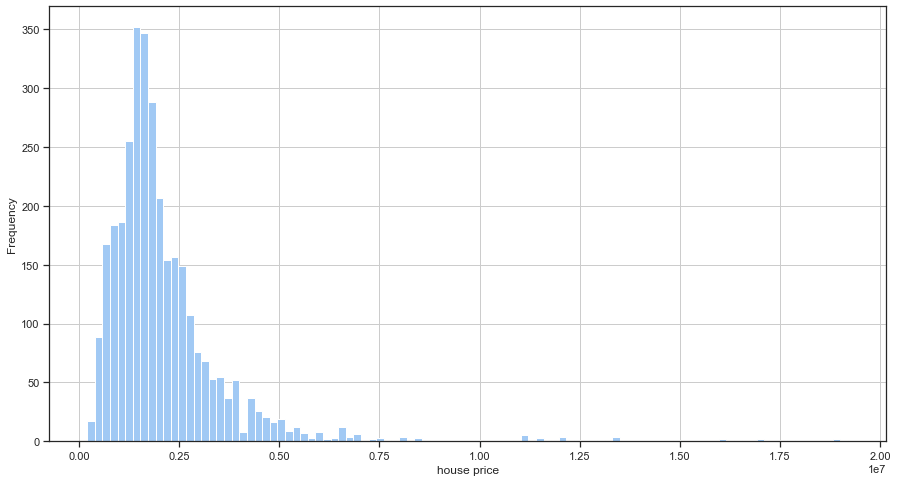

In [184]:
import matplotlib.pyplot as plt; 
import numpy as np
import seaborn as sns

plt.figure(figsize=(15,8))
df.price.hist(bins=100)
plt.xlabel('house price')
plt.ylabel('Frequency')

as you can see the mean house price is 1,800,000~  shekels ( we are in 10^7 scale on the x axis).

now, lets plot the histogram of home size:

Text(0.5, 0, 'area in square meter')

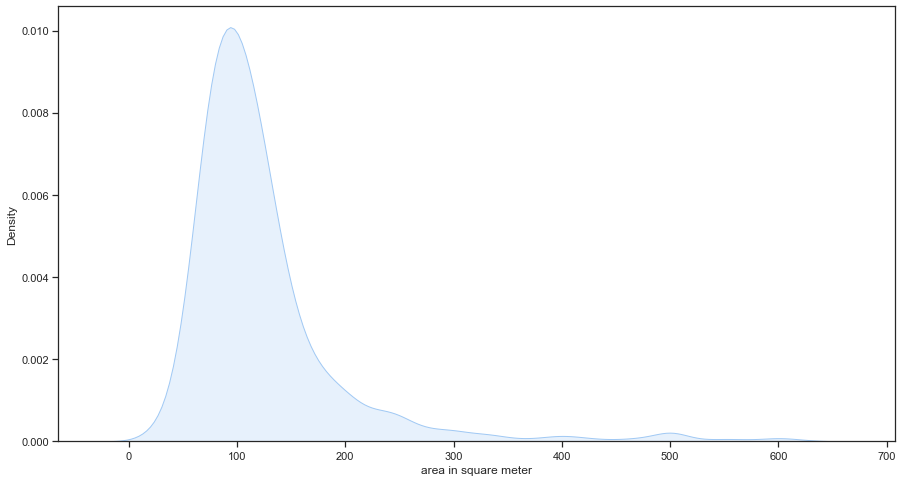

In [185]:
plt.figure(figsize=(15,8))
sns.kdeplot(df.area,  shade=True)
plt.xlabel('area in square meter')

as you can see the mean house size is 115~ squre meter

lets draw plot that shows the correlation between size and pirce

<AxesSubplot:xlabel='area', ylabel='price'>

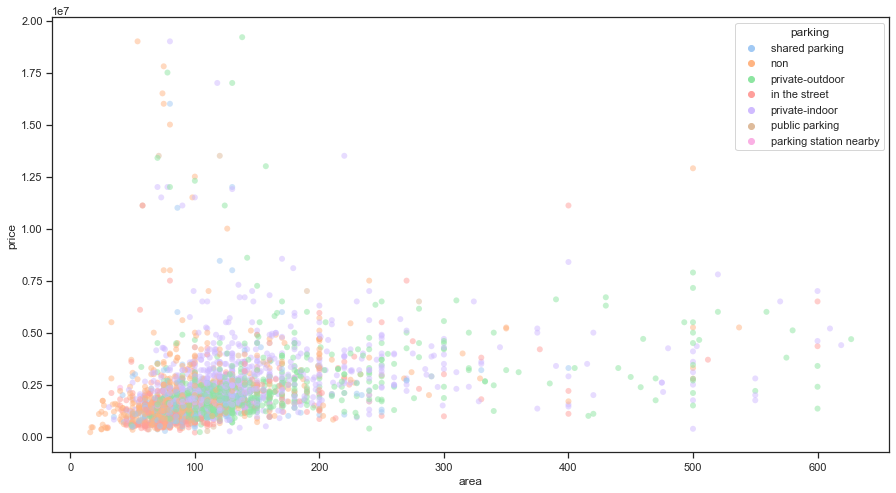

In [186]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="area", y="price",
                hue="parking", alpha=0.5,
                sizes=(1, 8), linewidth=0,
                data=df)

how does size correlate with rooms number?

<AxesSubplot:xlabel='area', ylabel='rooms'>

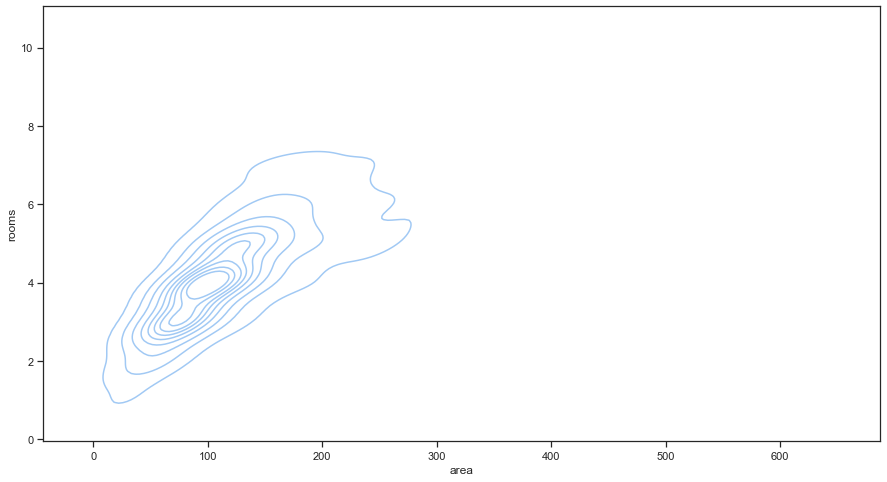

In [187]:
plt.figure(figsize=(15,8))
sns.kdeplot(data=df,  x="area",  y="rooms", thresh=.1)

lets look on the connection between house size the number of rooms in the hous and his price:

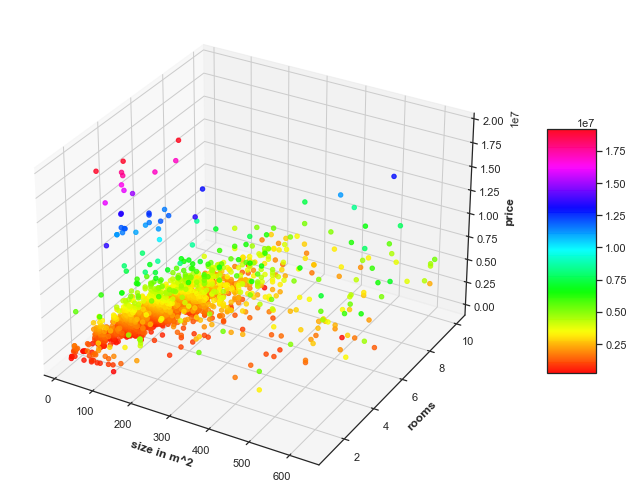

In [188]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (18, 9))
ax = plt.axes(projection ="3d")

my_cmap = plt.get_cmap('hsv')

x = df["area"]
y = df["rooms"]
z = df["price"]
sctt = ax.scatter3D(x, y, z, cmap = my_cmap, c = z ,alpha = 0.8 )


ax.set_xlabel('size in m^2', fontweight ='bold')
ax.set_ylabel('rooms', fontweight ='bold')
ax.set_zlabel('price', fontweight ='bold')

fig.colorbar(sctt, ax = ax, shrink = 0.5,  aspect = 5)

lest draw a pie chart that describes the distribution of different house types

([<matplotlib.patches.Wedge at 0x1726c7e6a30>,
 [Text(-0.6890464769148442, 0.8574467637417738, 'apartment'),
  Text(-0.13494908087787283, -1.09169077378634, 'cottage'),
  Text(0.09469214114650049, -1.0959166931866178, 'dual faimly'),
  Text(0.32326109690662747, -1.0514286771943802, 'duplex'),
  Text(0.6038004582711856, -0.9194699595916696, 'garden apartment'),
  Text(0.832907998393849, -0.7185153207911102, 'penthouse'),
  Text(0.9994252698223582, -0.45950966261930404, 'private house'),
  Text(1.0816256726091604, -0.20021464570001207, 'roof apartment'),
  Text(1.097887866759588, -0.06813392710010029, 'villa')],
 [Text(-0.37584353286264227, 0.4676982347682402, '71.5%'),
  Text(-0.0736085895697488, -0.5954676947925489, '3.0%'),
  Text(0.051650258807182076, -0.5977727417381551, '3.7%'),
  Text(0.17632423467634226, -0.5735065511969346, '3.1%'),
  Text(0.32934570451155576, -0.5015290688681833, '5.9%'),
  Text(0.45431345366937215, -0.3919174477042419, '2.9%'),
  Text(0.5451410562667408, -0.25

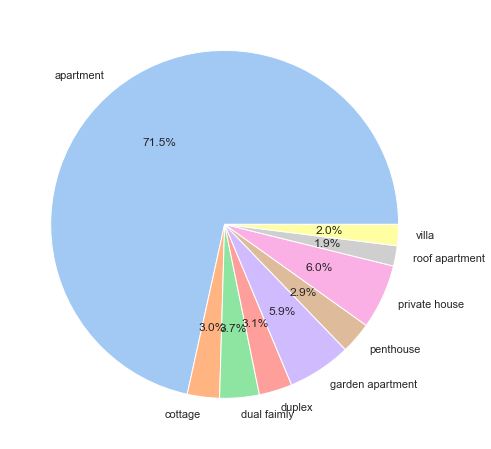

In [189]:
data = df.groupby("house type").count()
labels  = data.index.values.tolist()
data_list =  data['city'].tolist()


plt.figure(figsize=(15,8))
plt.pie(data_list, labels = labels, autopct='%.1f%%')

as you can see the seaborn library does not handle the hebrew language very well,
hence we will replace all the hebew text in the 'house type' coulmn with plain english and then run the code again.

now it will be nice to see whether having elevator in your apartment affect the price of the apartment.

but first we have to sort out all the homes that not qualified as apartmens

<AxesSubplot:xlabel='house type', ylabel='price'>

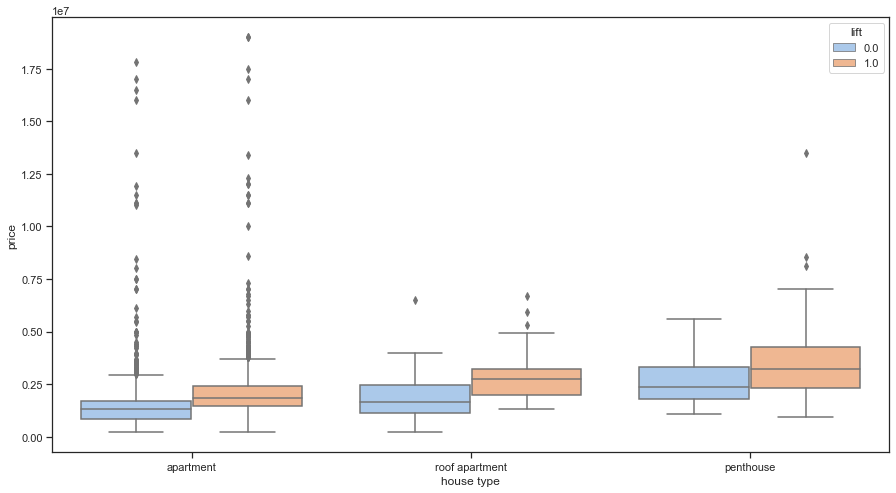

In [190]:
# filter where lift does matter  
apartment = df["house type"] == "apartment"
roof_apartment = df["house type"] == "roof apartment"
penthouse = df["house type"] == "penthouse"
apartments = df.where(apartment | roof_apartment | penthouse ).dropna()

# drawing the plot
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.boxplot(x="house type", y="price",  hue="lift", data=apartments)

its clear from the plot that exsiting of an elevator in the building corolate positivly with homes price 

now lets look what about furniture:

<AxesSubplot:xlabel='house type', ylabel='price'>

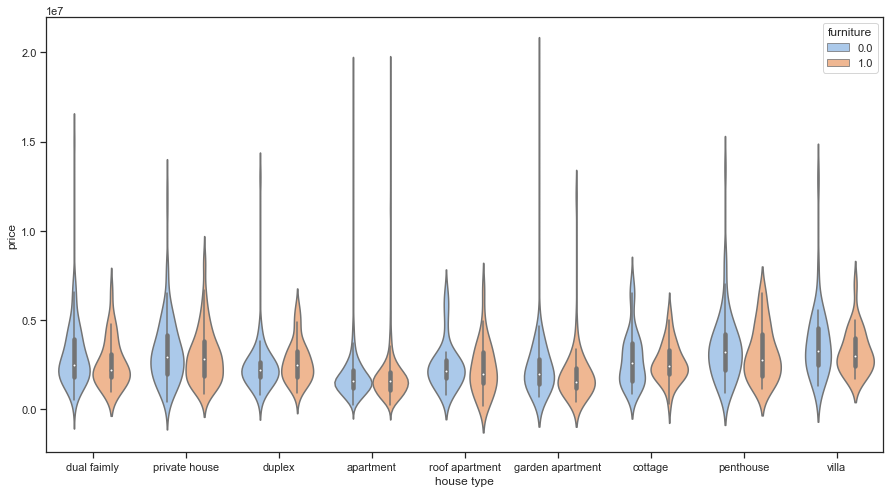

In [191]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.violinplot(x="house type", y="price",  hue="furniture", data=df)

there is no clear visible correlation between absence of furniture in the house and his price.

lastly, what about having bars in the house?

<AxesSubplot:xlabel='house type', ylabel='price'>

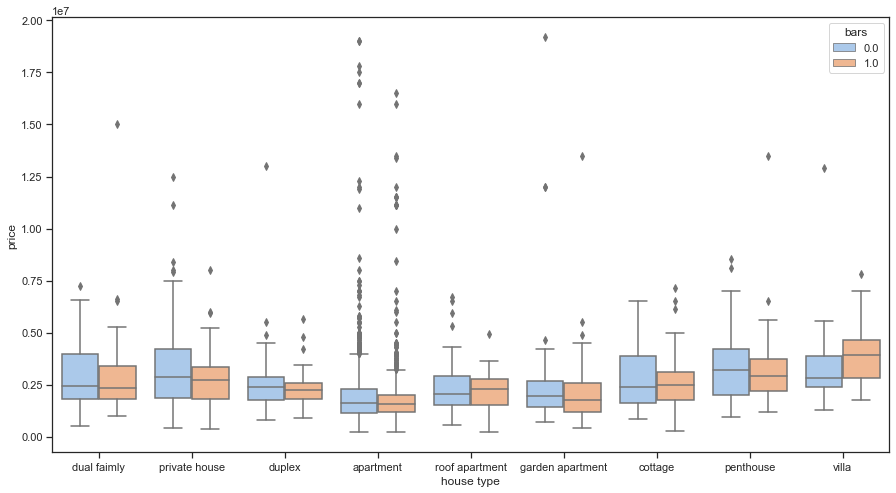

In [192]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(15,8))
sns.boxplot(x="house type", y="price",  hue="bars", data=df)

again, no clear effect on the house price

## Finding Correlations
lets found the correlations of the numeric values in our data set:

In [193]:
corr = df.corr()
  
corr

,price,area,rooms,bars,furniture,lift
price,1.000000,0.322365,0.253272,-0.060251,-0.037382,0.081091
area,0.322365,1.000000,0.653948,-0.062999,0.005839,-0.094548
rooms,0.253272,0.653948,1.000000,-0.029302,0.042454,-0.028261
bars,-0.060251,-0.062999,-0.029302,1.000000,0.103820,-0.063302
furniture,-0.037382,0.005839,0.042454,0.103820,1.000000,0.022414
lift,0.081091,-0.094548,-0.028261,-0.063302,0.022414,1.000000


lets plot it:

<AxesSubplot:>

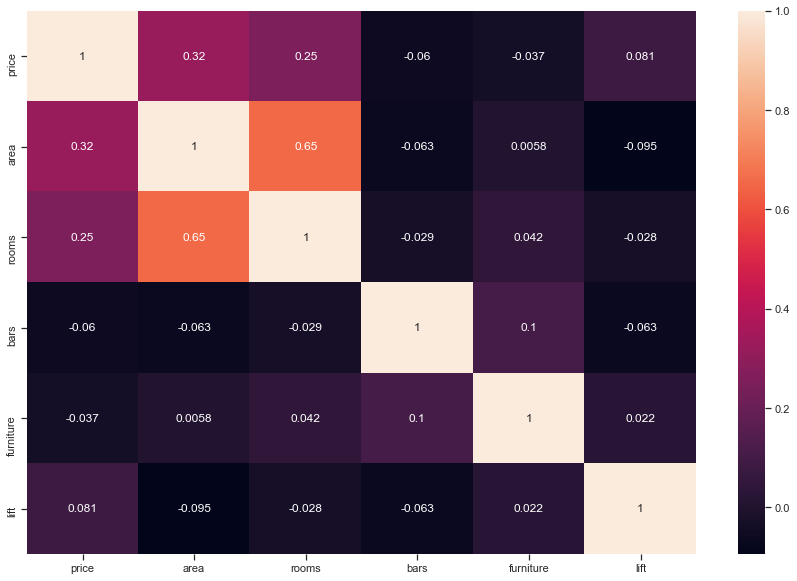

In [194]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

as you can see the highest correlation between price and other numeric parmater is area. but still correlation of 0.32 is consiederd quite low, so how we explain this?

as we already said we only took into calculation the numeric parmaters, but 'city' is not numeric and we know that it is among the crucial parmaters when determing house price.

###  Back to visiulistion

lets look on the 10 most frequent cities to apear in our data set

In [195]:
ten_most_popular_cities = df['city'].value_counts().index.tolist()[0:10]
ten_most_popular_cities

['Jerusalem',
 'Tel Aviv Jaffa',
 'Holon',
 'Haifa',
 'Rishon Lezion',
 'Beer Sheva',
 'Netanya',
 'Ashkelon',
 'Ramat Gan',
 'Petah Tiqwa']

now lets build new data frame consists only of the most popular cities

In [196]:
df_popular_cities = df[df['city'].isin(ten_most_popular_cities)]

df_popular_cities 

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition
0,Ramat Gan,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms
1,Ramat Gan,2750000.0,90.0,private house,4.0,1.0,0.0,0.0,non,in all the rooms
2,Tel Aviv Jaffa,13000000.0,157.0,duplex,6.0,0.0,0.0,1.0,private-outdoor,in the bedrooms
3,Tel Aviv Jaffa,1350000.0,57.0,apartment,2.5,1.0,1.0,0.0,in the street,in all the rooms
4,Beer Sheva,1570000.0,160.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms
...,...,...,...,...,...,...,...,...,...,...
3965,Ashkelon,1690000.0,147.0,apartment,5.0,1.0,0.0,1.0,private-indoor,central
3970,Tel Aviv Jaffa,6500000.0,170.0,apartment,5.0,1.0,1.0,1.0,private-outdoor,in all the rooms
3971,Beer Sheva,510000.0,72.0,apartment,3.0,0.0,1.0,1.0,shared parking,in all the rooms
3974,Rishon Lezion,1670000.0,90.0,apartment,4.0,0.0,0.0,1.0,private-indoor,in all the rooms


lets see what is the average home price in each city

Text(0.5, 1.0, 'average price by city')

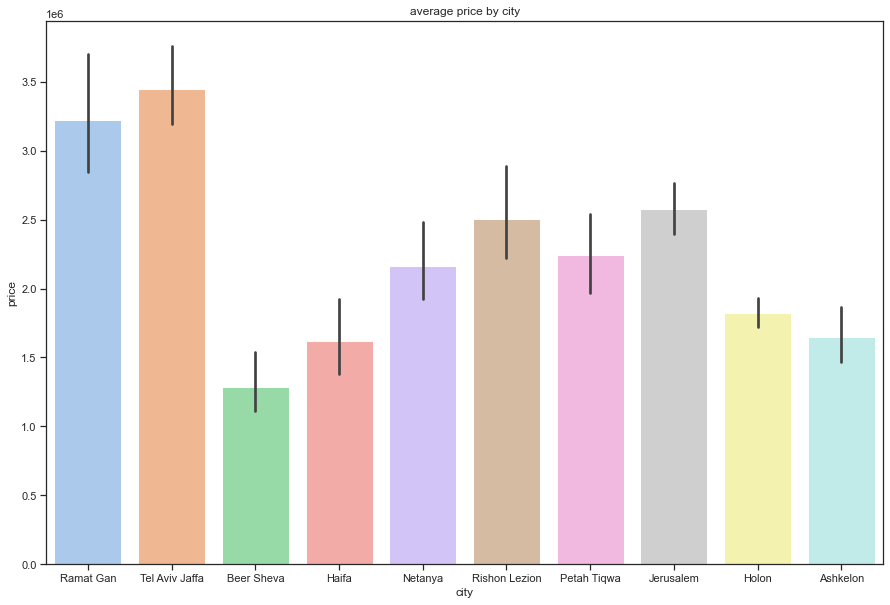

In [197]:
plt.figure(figsize=(15, 10))
sns.barplot(x = 'city', y = 'price' , data = df_popular_cities, edgecolor = 'w').set_title('average price by city')


we can see that the average price of house in the mose expensive city tel aviv the is almost 3.5 milion shekels.
while the price in the cheapest city in our list (haifa) is around 1.3 milion shekels.

Now lets look on average price for squre meter by city and house type.
for this we first have to find the average price and the average size for each city.

Text(0.5, 1.0, 'average price for squre meter by city and house type')

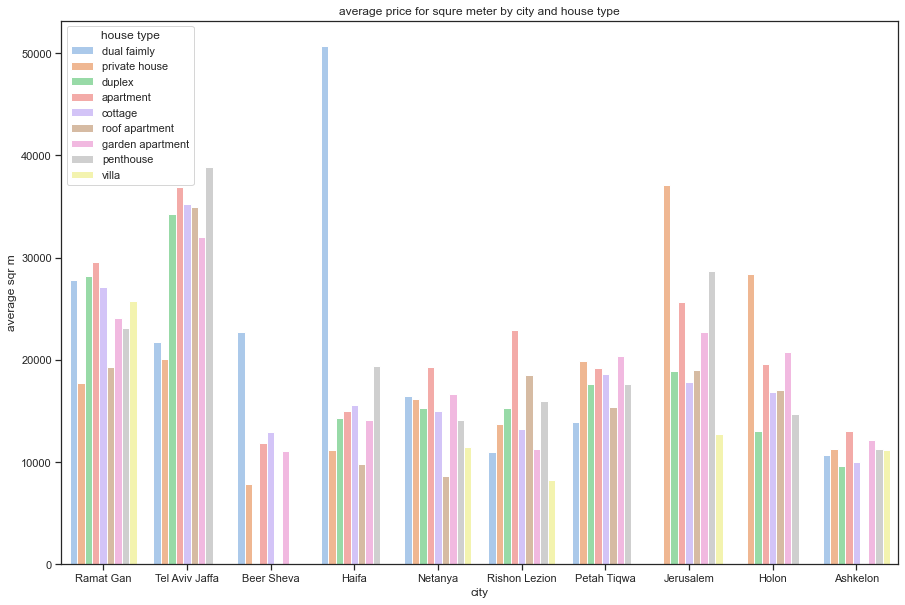

In [198]:
#founfing average size and average price
average_area = df_popular_cities.groupby(['city','house type'])["area"].mean()
average_area = average_area.to_frame()
average_area.columns = ['average area']

average_price = df_popular_cities.groupby(['city','house type'])["price"].mean()
average_price = average_price.to_frame()
average_price.columns = ['average price']

# merging
df_avg = pd.merge(average_price,average_area,on=['city','house type'])
df_popular_cities = pd.merge(df_popular_cities, df_avg, on=['city','house type'])
df_popular_cities["average sqr m"] =df_popular_cities["average price"] / df_popular_cities["average area"]

#ploting
plt.figure(figsize=(15, 10))
sns.barplot(x = 'city', y = 'average sqr m' , hue = "house type", data = df_popular_cities, edgecolor = 'w').set_title('average price for squre meter by city and house type')

we know that parking is scarce in tel aviv, can we see it in our data?

Text(0, 0.5, 'Relative frequency')

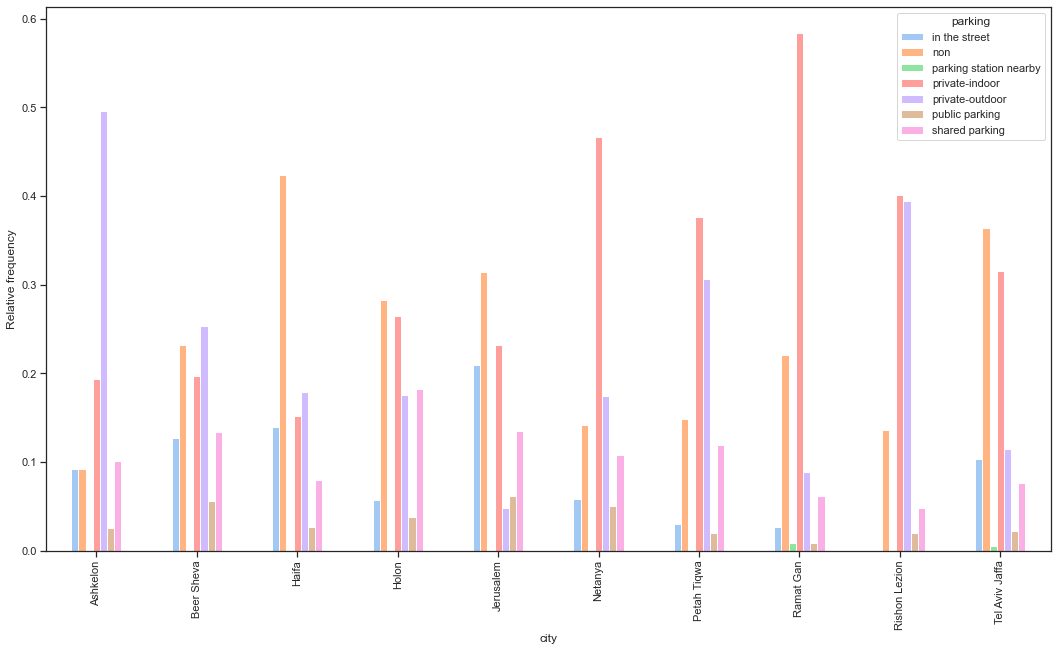

In [199]:
cross_tab =  pd.crosstab(df_popular_cities["city"], df_popular_cities["parking"], normalize ='index' )
cross_tab.plot(kind = 'bar', figsize=(18, 10))
plt.ylabel("Relative frequency")

40% of house for sale in tel aviv does not have parking, but the highest precentage for homes without parking found suprisly in haifa the cheapest city in our list (maybe we dont have enoguh data).

now, lets look how air condition effects the home price:

<AxesSubplot:xlabel='city', ylabel='price'>

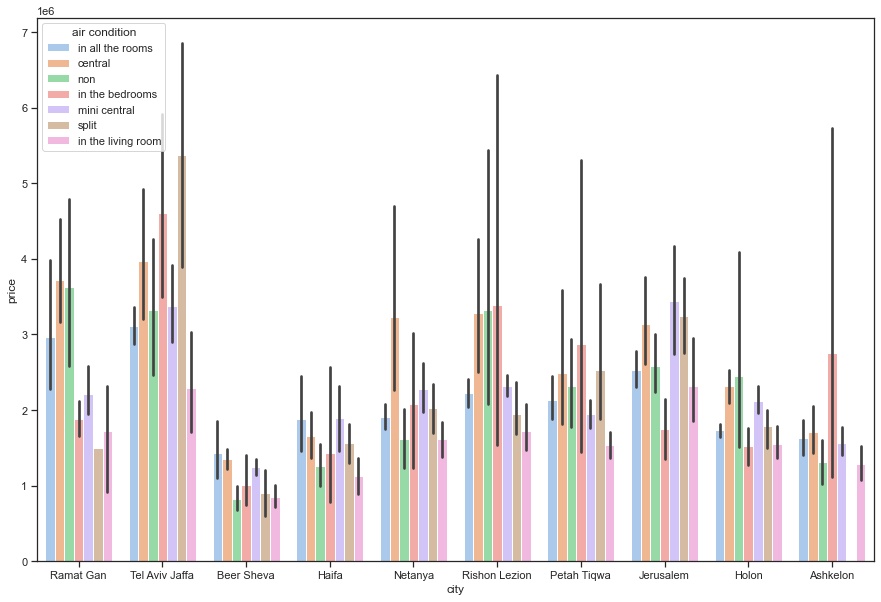

In [200]:
plt.figure(figsize=(15, 10))
sns.barplot(x = 'city', y = 'price', hue ='air condition', data = df_popular_cities, edgecolor = 'w')

lastly, lets look on disterbution of house types in different cities by price

C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\ronen\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.8% of the points c

[Text(0, 0.5, '')]

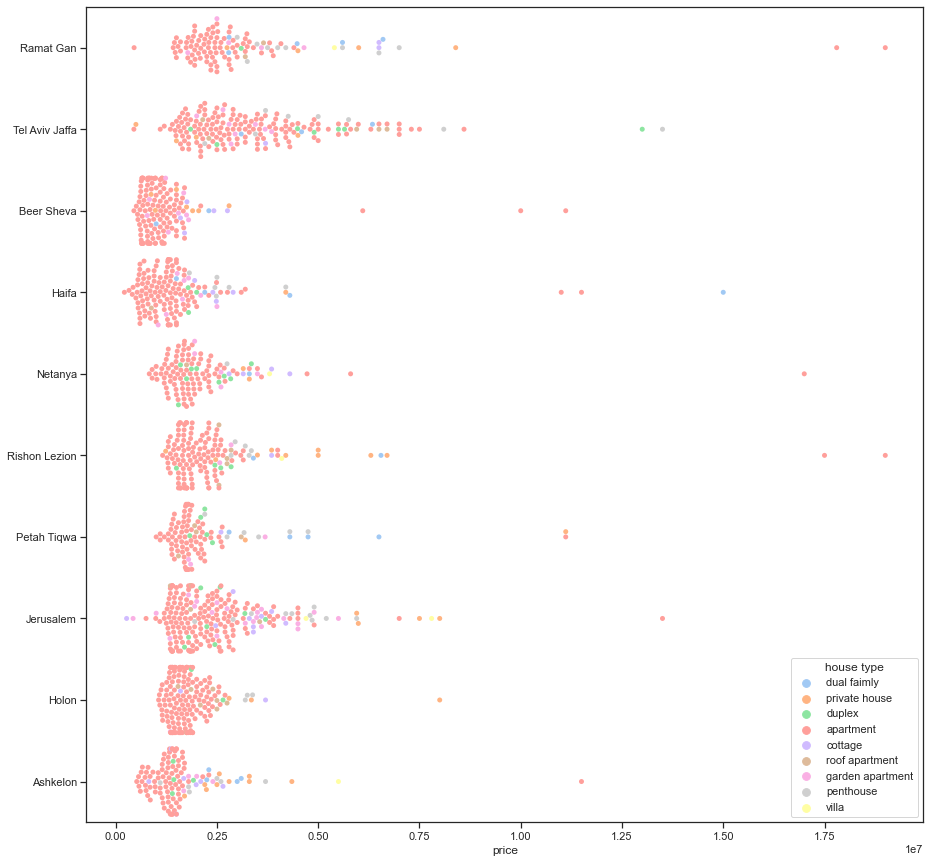

In [201]:
plt.figure(figsize=(15, 15))

ax = sns.swarmplot(data=df_popular_cities, x="price", y="city", hue="house type")
ax.set(ylabel="")

# Building model for predicting house price
after we explored the data we need to solve our inital problem: classifing a house price.

in oreder to achive this we have to build machine learning model, we will try to use decision trees and linaer regresion.

first, lets drop the redundent attirbutes that we add in the previous chapter to the data set


In [202]:
df = df_popular_cities.drop(['average price', 'average sqr m', 'average area'], axis = 'columns')
df.describe()

,price,area,rooms,bars,furniture,lift
count,1.465000e+03,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,2.291408e+06,111.723549,4.006485,0.443686,0.365188,0.503754
std,1.760961e+06,60.923186,1.207668,0.496988,0.481647,0.500157
min,2.150000e+05,16.000000,1.000000,0.000000,0.000000,0.000000
25%,1.400000e+06,78.000000,3.000000,0.000000,0.000000,0.000000
50%,1.840000e+06,100.000000,4.000000,0.000000,0.000000,1.000000
75%,2.600000e+06,124.000000,5.000000,1.000000,1.000000,1.000000
max,1.900000e+07,600.000000,10.000000,1.000000,1.000000,1.000000


We will now deal with price and area attributes, that the values of these two attributes are consecutive numbers, so we will divide them into intervals, according to the frequency graphs we presented above.

In [203]:
df['price_n'] = pd.cut(df['price'], 100)
df['price_n'] = pd.cut(df['price'],[0,500000,1000000,1500000,2000000,2500000,3000000,3500000,4000000,4500000,5000000,6000000,10000000,20000000,100000000], labels=[500,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,10000,20000,100000])
df= df.dropna()
df['price_n'].value_counts()
df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition,price_n
0,Ramat Gan,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,3000
1,Ramat Gan,2800000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,3000
2,Ramat Gan,4480000.0,140.0,dual faimly,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms,4500
3,Ramat Gan,6600000.0,390.0,dual faimly,6.5,1.0,1.0,0.0,private-outdoor,central,10000
4,Ramat Gan,5600000.0,90.0,dual faimly,4.0,0.0,0.0,0.0,non,non,6000
...,...,...,...,...,...,...,...,...,...,...,...
1460,Ashkelon,5500000.0,493.0,villa,10.0,0.0,0.0,0.0,private-outdoor,in all the rooms,6000
1461,Netanya,1750000.0,202.0,roof apartment,5.0,0.0,1.0,1.0,private-indoor,central,2000
1462,Ramat Gan,5400000.0,210.0,villa,6.5,1.0,0.0,0.0,private-indoor,central,6000
1463,Petah Tiqwa,2600000.0,140.0,cottage,5.0,1.0,1.0,0.0,non,in the bedrooms,3000


now lets convert the area attribute from continuous value into discrit value

In [204]:
df['area_n'] = pd.cut(df['area'],[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,300,400,700], labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])
df = df.dropna()
df

,city,price,area,house type,rooms,bars,furniture,lift,parking,air condition,price_n,area_n
0,Ramat Gan,2790000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,3000,8
1,Ramat Gan,2800000.0,90.0,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,3000,8
2,Ramat Gan,4480000.0,140.0,dual faimly,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms,4500,13
3,Ramat Gan,6600000.0,390.0,dual faimly,6.5,1.0,1.0,0.0,private-outdoor,central,10000,26
4,Ramat Gan,5600000.0,90.0,dual faimly,4.0,0.0,0.0,0.0,non,non,6000,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1460,Ashkelon,5500000.0,493.0,villa,10.0,0.0,0.0,0.0,private-outdoor,in all the rooms,6000,27
1461,Netanya,1750000.0,202.0,roof apartment,5.0,0.0,1.0,1.0,private-indoor,central,2000,20
1462,Ramat Gan,5400000.0,210.0,villa,6.5,1.0,0.0,0.0,private-indoor,central,6000,20
1463,Petah Tiqwa,2600000.0,140.0,cottage,5.0,1.0,1.0,0.0,non,in the bedrooms,3000,13


We will now split the data set into the classified properties, and the target variable

In [205]:
inputs = df.drop(['price','price_n','area'],axis = 'columns')
target = df['price_n']
target = target.to_frame()

We will replace the categorical variables with numeric variables  using the indexing method

In [206]:
from sklearn.preprocessing import LabelEncoder
le_city = LabelEncoder()
le_type = LabelEncoder()
le_parking = LabelEncoder()
le_air = LabelEncoder()

inputs['city_n'] = le_city.fit_transform(inputs['city'])
inputs['type_n'] = le_type.fit_transform(inputs['house type'])
inputs['parking_n'] = le_parking.fit_transform(inputs['parking'])
inputs['air_n'] = le_air.fit_transform(inputs['air condition'])

inputs

,city,house type,rooms,bars,furniture,lift,parking,air condition,area_n,city_n,type_n,parking_n,air_n
0,Ramat Gan,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,8,7,2,6,1
1,Ramat Gan,dual faimly,4.0,1.0,0.0,0.0,shared parking,in all the rooms,8,7,2,6,1
2,Ramat Gan,dual faimly,4.0,0.0,0.0,0.0,private-outdoor,in all the rooms,13,7,2,4,1
3,Ramat Gan,dual faimly,6.5,1.0,1.0,0.0,private-outdoor,central,26,7,2,4,0
4,Ramat Gan,dual faimly,4.0,0.0,0.0,0.0,non,non,8,7,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,Ashkelon,villa,10.0,0.0,0.0,0.0,private-outdoor,in all the rooms,27,0,8,4,1
1461,Netanya,roof apartment,5.0,0.0,1.0,1.0,private-indoor,central,20,5,7,3,0
1462,Ramat Gan,villa,6.5,1.0,0.0,0.0,private-indoor,central,20,7,8,3,0
1463,Petah Tiqwa,cottage,5.0,1.0,1.0,0.0,non,in the bedrooms,13,6,1,1,2


again, we will get rid from the redundant attributes

after that we will be left with only numeric values in our data set

In [207]:
inputs_n = inputs.drop(['city','house type','parking','air condition'],axis = 'columns')
inputs_n

,rooms,bars,furniture,lift,area_n,city_n,type_n,parking_n,air_n
0,4.0,1.0,0.0,0.0,8,7,2,6,1
1,4.0,1.0,0.0,0.0,8,7,2,6,1
2,4.0,0.0,0.0,0.0,13,7,2,4,1
3,6.5,1.0,1.0,0.0,26,7,2,4,0
4,4.0,0.0,0.0,0.0,8,7,2,1,5
...,...,...,...,...,...,...,...,...,...
1460,10.0,0.0,0.0,0.0,27,0,8,4,1
1461,5.0,0.0,1.0,1.0,20,5,7,3,0
1462,6.5,1.0,0.0,0.0,20,7,8,3,0
1463,5.0,1.0,1.0,0.0,13,6,1,1,2


In [208]:
lcity = [12, 13,  2,  1,  5, 11,  9, 10,  7,  3,  8,  6,  4,  0]
ltype = [ 1,  0,  2,  3,  4, 11,  5,  7, 10,  9,  8,  6]
llift = [0, 1]
lbars = [0, 1]
lroom = [ 4. ,  6. ,  2.5,  3. ,  5. ,  2. ,  1. ,  4.5,  3.5,  1.5,  7. , 6.5,  5.5, 10. ,  8. ,  9. ]
lfun = [0, 1]
lpark = [2, 0, 4, 1, 5, 6, 3]
lair = [2, 1, 0, 5, 3, 4, 6]
lprice = ['500','1000','1500','2000','2500','3000','3500','4000','4500','5000','6000','10000','20000','100000']

feature_names=[lroom,lbars, lfun, llift, lcity, ltype ,lpark,lair] 

## Training the model
we will import the DecisionTreeClassifier class from sklearn and then train the model.
lets start with simple tree that has a max depth of 2

In [209]:
from sklearn import tree
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
model = model.fit(inputs_n, target)

model.score(inputs_n, target)

0.36450511945392494

as you can see, the tree classifies only 31% of the data set correctly

now, lets graph the tree:

In [210]:
text_representation = tree.export_text(model)
text_representation

'|--- feature_5 <= 2.50\n|   |--- feature_4 <= 10.50\n|   |   |--- class: 1000\n|   |--- feature_4 >  10.50\n|   |   |--- class: 1500\n|--- feature_5 >  2.50\n|   |--- feature_4 <= 9.50\n|   |   |--- class: 2000\n|   |--- feature_4 >  9.50\n|   |   |--- class: 2500\n'

its hard to get grasp of what is going on from this repersention,
so we will use the the graphviz labriry instead.

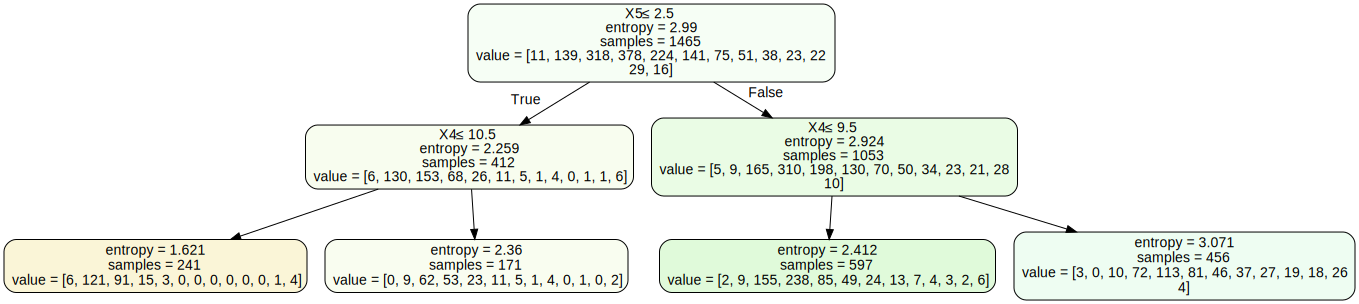

In [211]:
import graphviz
dot_data = tree.export_graphviz(model, out_file=None, filled=True, rounded=True, 
special_characters=True)
graph = graphviz.Source(dot_data)
graph

lets see what happens if not specify max depth for the tree

In [212]:
model = tree.DecisionTreeClassifier(criterion='entropy')
model = model.fit(inputs_n, target)

model.score(inputs_n, target)

0.9720136518771331

97.1%, we could say its quite better than 31%.
but we only test the training set, that is not quite fair

## Testing different models

now lets see how our tree performs on the testing set

In [213]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

x_train, x_test, y_train, y_test = train_test_split(inputs_n, target, test_size=0.1,random_state=0)

modell = tree.DecisionTreeClassifier(criterion='entropy')
modell = modell.fit(x_train, y_train)
modell.score(x_test, y_test)

0.3673469387755102

35.4% accuracy, not so impresive...

lets try regresion in decision tree

In [214]:
from sklearn import metrics

dt = DecisionTreeRegressor(min_samples_leaf=0.1,random_state=0)
y_tr = y_train['price_n']
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)
metrics.r2_score(y_test,y_pred)

dt.score(x_test,y_test)

0.128938040889239

tha accuracy in the regresion method is even worse,

what about cross validtion algorithm?

In [215]:
from sklearn.model_selection import cross_val_score

across = cross_val_score(modell,inputs_n, target,cv=20)
across.mean()

C:\Users\ronen\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 11 members, which is less than n_splits=20.
  warnings.warn(("The least populated class in y has only %d"


0.35096260644205846

37% a little bit better than our original tree

lastly, lets try  decision Tree forest, maybe it will help us to overcome the overfiting in our model

In [216]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, criterion= 'entropy')

rf.fit(x_train, y_train)
rf.score(x_test, y_test)

<ipython-input-216-48701bcfb5b5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


0.47619047619047616

yes!!!, not a great sucsess but 46.9% is quite of improvment compare to our 35.4 oringal accuracy

lets see what parametes causes the increase in accuracy of the forest algorithm

In [217]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2,3,4,5]
for f,d in product(max_features,max_depths):
        rf = RandomForestClassifier(n_estimators = n_estimators,
                                    criterion= 'entropy',
                                    max_features=f,
                                    max_depth= d,
                                    n_jobs =2,
                                    random_state=1337
                                )
        rf.fit(x_train, y_train)
        print('max_feature = {}, max_depth = {}: {:.3f}'.format(f,d,rf.score(x_test, y_test)))

<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = 1, max_depth = None: 0.388


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = 1, max_depth = 2: 0.333
max_feature = 1, max_depth = 3: 0.354


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = 1, max_depth = 4: 0.361
max_feature = 1, max_depth = 5: 0.381


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = sqrt, max_depth = None: 0.442
max_feature = sqrt, max_depth = 2: 0.327


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = sqrt, max_depth = 3: 0.422
max_feature = sqrt, max_depth = 4: 0.442


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = sqrt, max_depth = 5: 0.408


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = log2, max_depth = None: 0.442


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = log2, max_depth = 2: 0.327
max_feature = log2, max_depth = 3: 0.422


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


max_feature = log2, max_depth = 4: 0.442
max_feature = log2, max_depth = 5: 0.408


<ipython-input-217-ae0ad576dbc0>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


it seems that the parameters with the highest accuracy are:
    
max_feature = log2, max_depth = None: 0.483

or

max_feature = sqrt, max_depth = None: 0.483

#  final taughts

As we have seen we couldnt predict house price in accurecy higher than 43%, perhapse our data set is lacking some features(for instance we dont consider in our data how neighborhood or the area of the garden could affect the house price).
We believe that with more robust data we can build higher quality model.

fortunatly in these days we working on building new  data scrapper. the new scrapper produces data set that acceed the data set in this project both by volume  by veraity and numbers of features.
in the new data set there are 55,000 different homes with 18 features for each home (compare to only 4000 homes and 10 features).

hofefully with the new data we will build more precies decesion trees and even try training more models such as neural networks. 